# SQLite

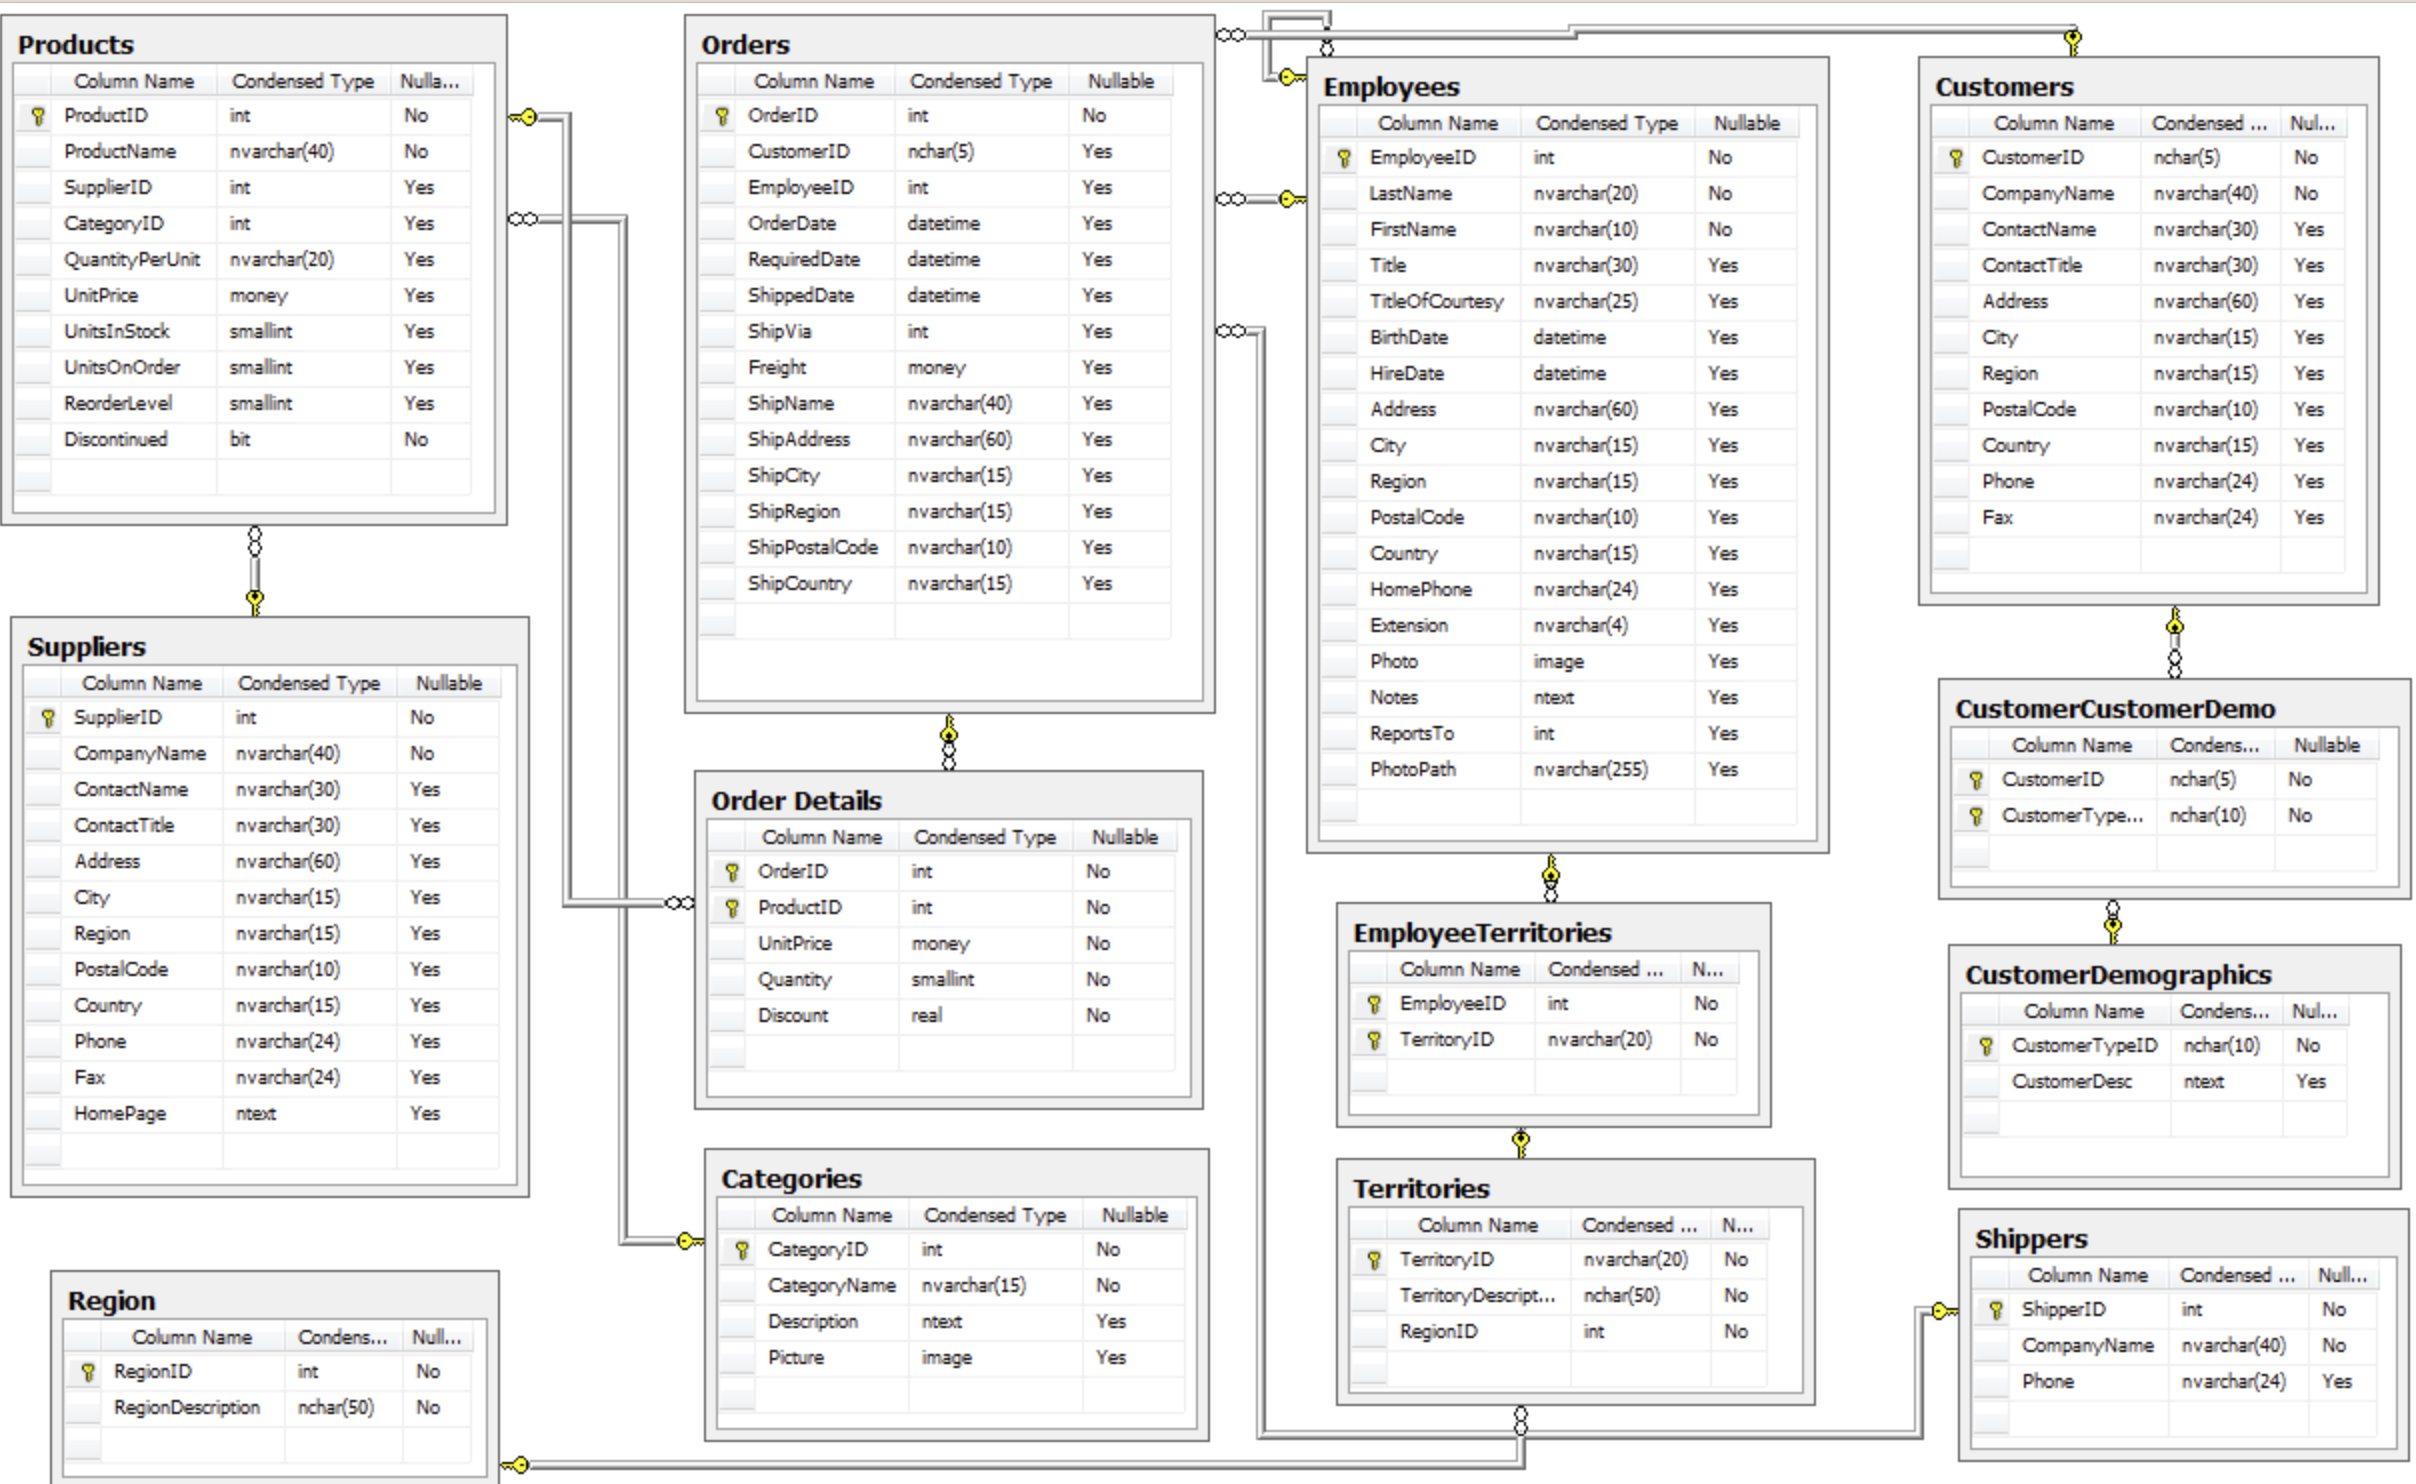

In [7]:
#Exercise 1, sqlite
import sqlite3
from pprint import pprint
from collections import defaultdict
conn = sqlite3.connect('northwind.db')
conn.text_factory = lambda x: str(x, 'latin1')
    
#construct query
query = """
SELECT Orders.OrderID, Products.ProductID, Products.CategoryID,  Products.ProductName
FROM Products 
    INNER JOIN [Order Details] ON Products.ProductID = [Order Details].ProductID
    INNER JOIN Orders ON Orders.OrderID == [Order Details].OrderID
WHERE Orders.CustomerID == "ALFKI"
"""

res = conn.execute(query)

#put result into a dictionary 
d = defaultdict(dict)
for row in res:
    d[row[0]][row[1]] = {"Cat":row[2], "Name":row[3]}
    
conn.close() #Close connection to DB after we are done processing

pprint(dict(d))


{10643: {28: {'Cat': 7, 'Name': 'Rössle Sauerkraut'},
         39: {'Cat': 1, 'Name': 'Chartreuse verte'},
         46: {'Cat': 8, 'Name': 'Spegesild'}},
 10692: {63: {'Cat': 2, 'Name': 'Vegie-spread'}},
 10702: {3: {'Cat': 2, 'Name': 'Aniseed Syrup'},
         76: {'Cat': 1, 'Name': 'Lakkalikööri'}},
 10835: {59: {'Cat': 4, 'Name': 'Raclette Courdavault'},
         77: {'Cat': 2, 'Name': 'Original Frankfurter grüne Soße'}},
 10952: {6: {'Cat': 2, 'Name': "Grandma's Boysenberry Spread"},
         28: {'Cat': 7, 'Name': 'Rössle Sauerkraut'}},
 11011: {58: {'Cat': 8, 'Name': 'Escargots de Bourgogne'},
         71: {'Cat': 4, 'Name': 'Flotemysost'}}}


In [8]:
def filterdict(d):
    result = d.copy()
    for order in d:
        categoryIDs = []
        for item in d[order]:
            categoryIDs.append(d[order][item]["Cat"])
        if len(set(categoryIDs)) < 2:
            result.pop(order)
    return result

d = filterdict(d)

pprint(dict(d))

{10643: {28: {'Cat': 7, 'Name': 'Rössle Sauerkraut'},
         39: {'Cat': 1, 'Name': 'Chartreuse verte'},
         46: {'Cat': 8, 'Name': 'Spegesild'}},
 10702: {3: {'Cat': 2, 'Name': 'Aniseed Syrup'},
         76: {'Cat': 1, 'Name': 'Lakkalikööri'}},
 10835: {59: {'Cat': 4, 'Name': 'Raclette Courdavault'},
         77: {'Cat': 2, 'Name': 'Original Frankfurter grüne Soße'}},
 10952: {6: {'Cat': 2, 'Name': "Grandma's Boysenberry Spread"},
         28: {'Cat': 7, 'Name': 'Rössle Sauerkraut'}},
 11011: {58: {'Cat': 8, 'Name': 'Escargots de Bourgogne'},
         71: {'Cat': 4, 'Name': 'Flotemysost'}}}


# MongoDB

In [9]:
from pymongo import MongoClient
from pprint import pprint
from collections import defaultdict

#Connect to Mongo-Session and the database.
client = MongoClient('localhost', 27017)
db = client["Northwind"]

#construct query
cursor = db.orders.aggregate([
    {
        "$match" : {"CustomerID" : "ALFKI"}
    },
    {
      '$lookup': {
          'from': "order-details",
          'localField': "OrderID",
          'foreignField': "OrderID",
          'as': "order"
        }
    },
    {
      '$lookup': {
          'from': "products",
          'localField': "order.ProductID",
          'foreignField': "ProductID",
          'as': "order.products"
        }
    }, 
    {
        '$project': {
            "OrderID" : 1,
            "order.products.ProductID" : 1,
            "order.products.CategoryID" : 1,
            "order.products.ProductName" : 1
        }
    }
    
])

#Put the result into a dictionary
d = defaultdict(dict)
for row in cursor:
    for product in row["order"]["products"]:
        d[row["OrderID"]][product["ProductID"]] = {"Cat" : product["CategoryID"], "Name" : product["ProductName"]}
        
pprint(dict(d))

{10643: {28: {'Cat': 7, 'Name': 'Rössle Sauerkraut'},
         39: {'Cat': 1, 'Name': 'Chartreuse verte'},
         46: {'Cat': 8, 'Name': 'Spegesild'}},
 10692: {63: {'Cat': 2, 'Name': 'Vegie-spread'}},
 10702: {3: {'Cat': 2, 'Name': 'Aniseed Syrup'},
         76: {'Cat': 1, 'Name': 'Lakkalikööri'}},
 10835: {59: {'Cat': 4, 'Name': 'Raclette Courdavault'},
         77: {'Cat': 2, 'Name': 'Original Frankfurter grüne Soße'}},
 10952: {6: {'Cat': 2, 'Name': "Grandma's Boysenberry Spread"},
         28: {'Cat': 7, 'Name': 'Rössle Sauerkraut'}},
 11011: {58: {'Cat': 8, 'Name': 'Escargots de Bourgogne'},
         71: {'Cat': 4, 'Name': 'Flotemysost'}}}


In [10]:
d = filterdict(d)
pprint(dict(d))

{10643: {28: {'Cat': 7, 'Name': 'Rössle Sauerkraut'},
         39: {'Cat': 1, 'Name': 'Chartreuse verte'},
         46: {'Cat': 8, 'Name': 'Spegesild'}},
 10702: {3: {'Cat': 2, 'Name': 'Aniseed Syrup'},
         76: {'Cat': 1, 'Name': 'Lakkalikööri'}},
 10835: {59: {'Cat': 4, 'Name': 'Raclette Courdavault'},
         77: {'Cat': 2, 'Name': 'Original Frankfurter grüne Soße'}},
 10952: {6: {'Cat': 2, 'Name': "Grandma's Boysenberry Spread"},
         28: {'Cat': 7, 'Name': 'Rössle Sauerkraut'}},
 11011: {58: {'Cat': 8, 'Name': 'Escargots de Bourgogne'},
         71: {'Cat': 4, 'Name': 'Flotemysost'}}}


# Make your own

In [14]:
import sqlite3
conn = sqlite3.connect('northwind.db')
conn.text_factory = lambda x: str(x, 'latin1')
    
query = """
SELECT Orders.EmployeeID, count(*), Employees.FirstName, Employees.LastName
    FROM Orders INNER JOIN Employees ON Orders.EmployeeID = Employees.EmployeeID
GROUP BY Orders.EmployeeID
ORDER BY count(*) DESC
"""
cursor = conn.execute(query)
print("(ID, Number of Orders, First name, Last name)")
for row in cursor:
    print(row)
    
conn.close()

(ID, Number of Orders, First name, Last name)
(4, 156, 'Margaret', 'Peacock')
(3, 127, 'Janet', 'Leverling')
(1, 123, 'Nancy', 'Davolio')
(8, 104, 'Laura', 'Callahan')
(2, 96, 'Andrew', 'Fuller')
(7, 72, 'Robert', 'King')
(6, 67, 'Michael', 'Suyama')
(9, 43, 'Anne', 'Dodsworth')
(5, 42, 'Steven', 'Buchanan')


In [15]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client["Northwind"]

cursor = db.orders.aggregate([
    {
        "$group": {
        "_id": "$EmployeeID",
        "count": { "$sum": 1 }
        }
    },
    {
        "$sort": { "count": -1 } 
    },
    {
        "$lookup" : {
          'from': "employees",
          'localField': "_id",
          'foreignField': "EmployeeID",
          'as': "empl"
        }
    },
    {
        "$project" : {
            "EmployeeID" : 1,
            "count" : 1,
            "empl.FirstName": 1,
            "empl.LastName": 1
        }
    }
])

print("(ID, Number of Orders, First name, Last name)")
for row in cursor:
    print(row["_id"], row["count"], row["empl"][0]["FirstName"], row["empl"][0]["LastName"], sep=', ')

(ID, Number of Orders, First name, Last name)
4, 156, Margaret, Peacock
3, 127, Janet, Leverling
1, 123, Nancy, Davolio
8, 104, Laura, Callahan
2, 96, Andrew, Fuller
7, 72, Robert, King
6, 67, Michael, Suyama
9, 43, Anne, Dodsworth
5, 42, Steven, Buchanan
